# 2487 Machine Learning Assignment 4
#Inside Out
![](https://upload.wikimedia.org/wikipedia/en/0/0a/Inside_Out_%282015_film%29_poster.jpg)




Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.

Your task is to use deep learning techniques to classify the Tweets into the corresponding emotions:

In [ ]:
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
!pip install "tf-models-official==2.13.*"

In [ ]:
!pip install datasets transformers cohere

In [ ]:
import re
import string
from string import punctuation
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from datasets import load_dataset

from ml_utils import *

seed = 666

keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
#tf.config.experimental.enable_op_determinism()

In [ ]:
emotion = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Data Fields

The data fields are:

- text: a string feature.
- label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [ ]:
emotion['train'][0]['text'],emotion['train'][0]['label'],emotion['train'].features

('i didnt feel humiliated',
 0,
 {'text': Value(dtype='string', id=None),
  'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)})

In [ ]:
emotion['validation'][0]['text'],emotion['validation'][0]['label']

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
emotion['test'][0]['text'],emotion['test'][0]['label']

('im feeling rather rotten so im not very ambitious right now', 0)

split: with a total of 20_000 examples split into train, validation and split

In [ ]:
emotion['train'].shape, emotion['validation'].shape, emotion['test'].shape

((16000, 2), (2000, 2), (2000, 2))

## Question 1 (40 points)
- Check the distribution of the text length in the data,
- build the simple RNN model and LSTM model with one layer, and two stacked layers, respectively and compare their performance.
* You may choose to pad or truncate the input sequence to be the number closest to 128, 256, 512, etc. You could train at most for 10 epochs if you find it takes much time.

In [ ]:
all_texts = emotion['train']['text'] + emotion['validation']['text'] + emotion['test']['text']

In [ ]:
allTextsDF = pd.DataFrame()

for ds, ds_type in zip([emotion['train'], emotion['validation'], emotion['test']], ['train', 'validation', 'test']):
    opDF = pd.DataFrame(data = {'text': ds['text'], 'label': ds['label']})
    opDF['ds_type'] = ds_type
    allTextsDF = pd.concat([allTextsDF, opDF])
    del opDF


In [ ]:
allTextsDF['n_tokens'] = allTextsDF.text.str.strip().str.split(' ').str.len()

Text(0.5, 1.0, 'Distribution of lengths in tokens')

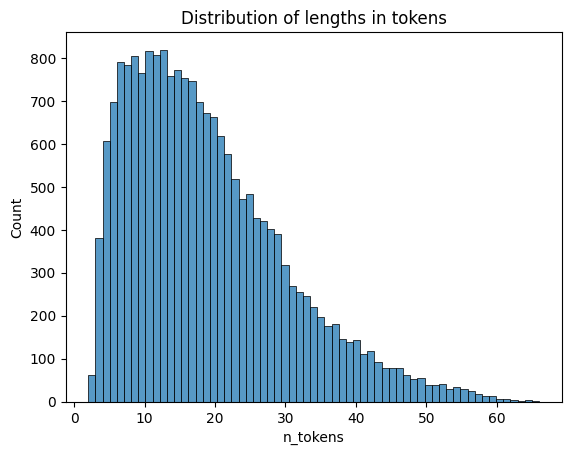

In [ ]:
sns.histplot(data=allTextsDF['n_tokens'])
plt.title('Distribution of lengths in tokens')

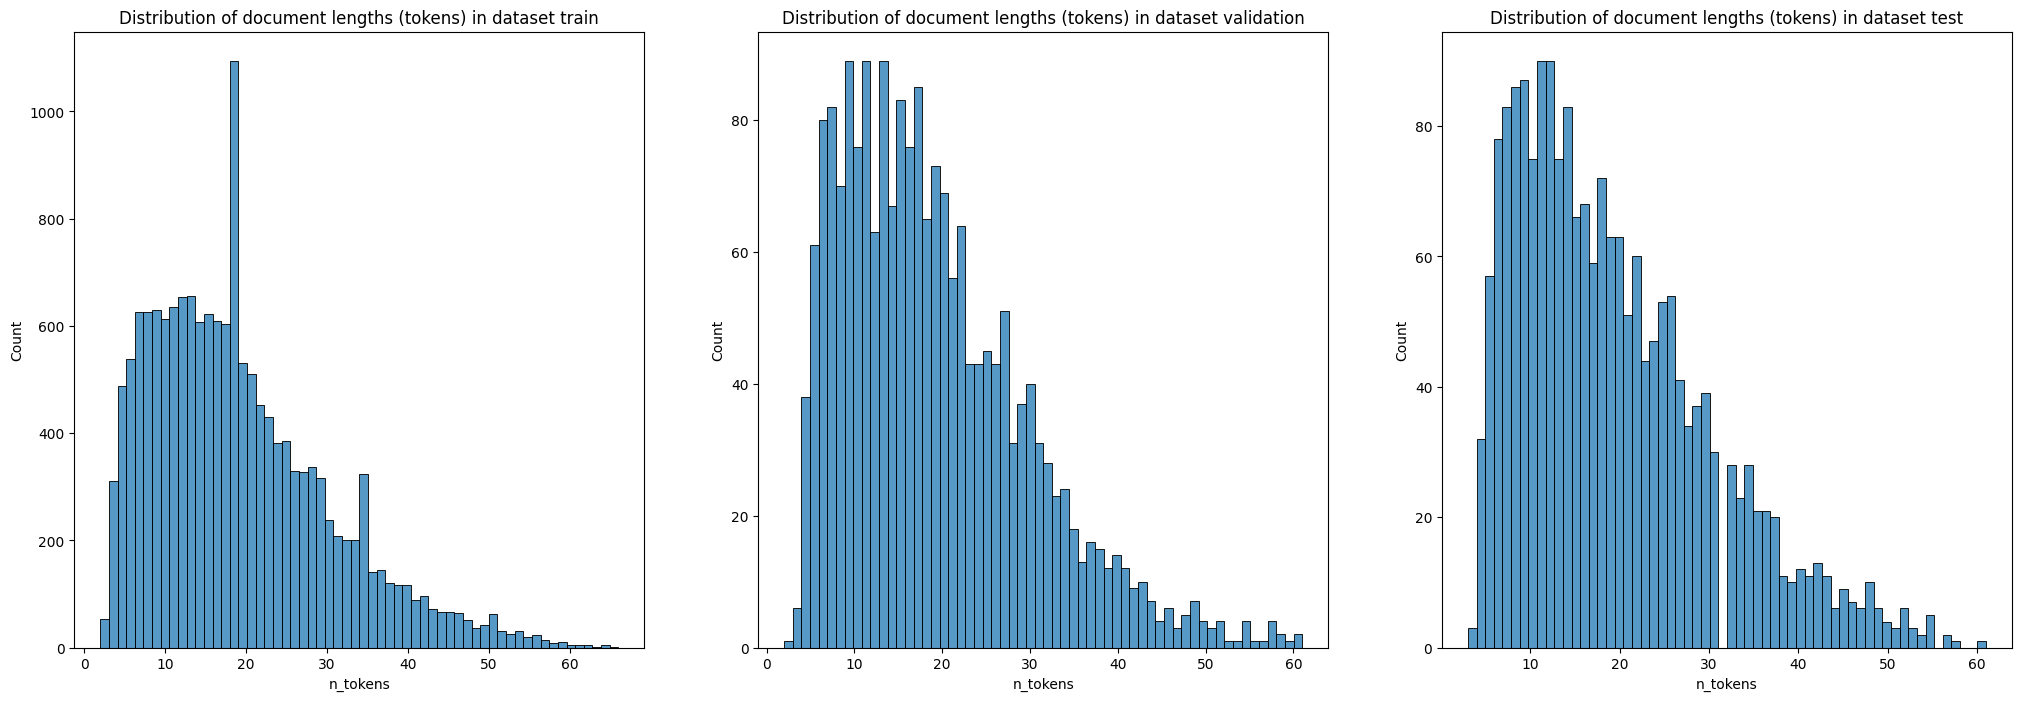

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,8))
#fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,25))

for i, v in enumerate(('train', 'validation', 'test')):
    sns.histplot(data=allTextsDF.loc[allTextsDF.ds_type==v , 'n_tokens'], ax=ax[i], bins=60)
    ax[i].set_title(f'Distribution of document lengths (tokens) in dataset {v}')

#### Training Datasets for Tensorflow Models

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [ ]:
train_ds = df_to_dataset(allTextsDF.loc[allTextsDF.ds_type=='train', ['text', 'label']])
val_ds = df_to_dataset(allTextsDF.loc[allTextsDF.ds_type=='validation', ['text', 'label']])
test_ds = df_to_dataset(allTextsDF.loc[allTextsDF.ds_type=='test', ['text', 'label']])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Vectorisation Layer

In [ ]:
from collections import Counter
import numpy as np

def unique_word_count(strings, top_percent=100):
    # Combine all strings into one large string
    all_text = ' '.join(strings)

    # Split the string into words
    words = all_text.split()

    # Count the frequency of each word
    word_counts = Counter(words)

    # If top_percent is 100, return the total unique words
    if top_percent == 100:
        return len(word_counts)

    # Get the frequencies of the words
    frequencies = list(word_counts.values())

    # Calculate the threshold for the top percent
    threshold = np.percentile(frequencies, 100 - top_percent)

    # Count the words that meet the frequency threshold
    filtered_words = [word for word, count in word_counts.items() if count >= threshold]

    return len(filtered_words)

In [ ]:
unique_word_count(emotion['train']['text'], 80)

15212

In [ ]:
output_dim = 64

def custom_standardization(input_text):
    """Lowercase and remove punctuation from the text."""
    lowercase_text = tf.strings.lower(input_text)
    cleaned_text = tf.strings.regex_replace(lowercase_text, '[%s]' % re.escape(string.punctuation), '')
    return cleaned_text

# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=15000,
    output_mode='int',
    output_sequence_length=output_dim,
    standardize=custom_standardization
)

# Assuming `texts` is a list or dataset of your text data
vectorize_layer.adapt(emotion['train']['text'])

#### RNN Models

In [ ]:
keras.backend.clear_session()

In [ ]:
model_rnn_1 = create_rnn_model(vectorize_layer=vectorize_layer,
                               embedding_dim=200,
                               rnn_units=32,
                               num_rnn_layers=1,
                               num_classes=6,
                               seed=seed,
                               dropout_rate=0,
                               l2_lambda=0)

model_rnn_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 64, 200)           3000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                7456      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                             

In [ ]:
epochs=20

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [ ]:
# Fit the model with the early stopping callback

start_time = time.time()

history = model_rnn_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 33s 62ms/step - loss: 1.2278 - accuracy: 0.5542 - val_loss: 0.7833 - val_accuracy: 0.7470
Epoch 2/20
500/500 [==============================] - 34s 69ms/step - loss: 0.4715 - accuracy: 0.8518 - val_loss: 0.6521 - val_accuracy: 0.8085
Epoch 3/20
500/500 [==============================] - 35s 70ms/step - loss: 0.3082 - accuracy: 0.9045 - val_loss: 0.7623 - val_accuracy: 0.7760
Epoch 4/20
500/500 [==============================] - 40s 80ms/step - loss: 0.2037 - accuracy: 0.9374 - val_loss: 0.5829 - val_accuracy: 0.8375
Epoch 5/20
500/500 [==============================] - 25s 51ms/step - loss: 0.1607 - accuracy: 0.9523 - val_loss: 0.6231 - val_accuracy: 0.8325
Epoch 6/20
500/500 [==============================] - 26s 52ms/step - loss: 0.1051 - accuracy: 0.9688 - val_loss: 0.6822 - val_accuracy: 0.8245
Epoch 7/20
500/500 [==============================] - 32s 63ms/step - loss: 0.0753 - accuracy: 0.9787 - val_loss: 0.6975 - val_accuracy:

In [ ]:
results_df = evaluate_and_log_model(model_rnn_1, 'One Layer RNN', test_ds, time_delta, train_epochs)

63/63 [==============================] - 0s 6ms/step - loss: 0.7231 - accuracy: 0.8105
Test Loss: 0.72307288646698, Test Accuracy: 0.8105000257492065


In [ ]:
results_df

,model,test_loss,test_accuracy,training_time,n_epochs,avg_epoch_time
0,One Layer RNN,0.723073,0.8105,246.815577,7,35.259368


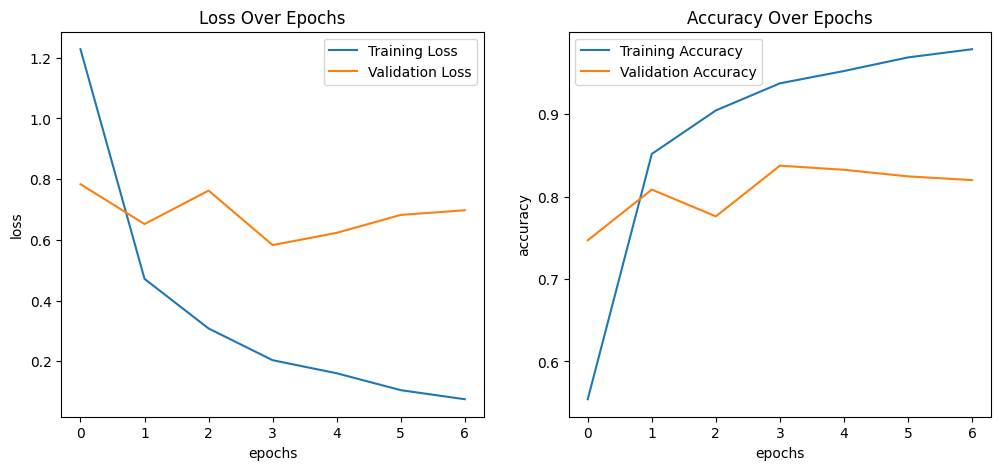


Final Training Loss: 0.0753
Final Validation Loss: 0.6975
Final Training Accuracy: 0.9787
Final Validation Accuracy: 0.8200


In [ ]:
plot_history(history)

In [ ]:
model_rnn_1_reg = create_rnn_model(vectorize_layer=vectorize_layer,
                                   embedding_dim=200,
                                   rnn_units=32,
                                   num_rnn_layers=1,
                                   num_classes=6,
                                   seed=seed,
                                   dropout_rate=0.3,
                                   l2_lambda=0.001)

model_rnn_1_reg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 64, 200)           3000000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                7456      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                           

In [ ]:

start_time = time.time()
# Fit the model with the early stopping callback
history = model_rnn_1_reg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 41s 82ms/step - loss: 1.1265 - accuracy: 0.7641 - val_loss: 1.0966 - val_accuracy: 0.7910
Epoch 2/20
500/500 [==============================] - 34s 67ms/step - loss: 1.0229 - accuracy: 0.8134 - val_loss: 1.3142 - val_accuracy: 0.7195
Epoch 3/20
500/500 [==============================] - 37s 75ms/step - loss: 0.9161 - accuracy: 0.8422 - val_loss: 0.9275 - val_accuracy: 0.8380
Epoch 4/20
500/500 [==============================] - 33s 66ms/step - loss: 0.8868 - accuracy: 0.8549 - val_loss: 0.9784 - val_accuracy: 0.8235
Epoch 5/20
500/500 [==============================] - 38s 76ms/step - loss: 0.8183 - accuracy: 0.8697 - val_loss: 0.8783 - val_accuracy: 0.8470
Epoch 6/20
500/500 [==============================] - 30s 60ms/step - loss: 0.9807 - accuracy: 0.8092 - val_loss: 1.3221 - val_accuracy: 0.6775
Epoch 7/20
500/500 [==============================] - 34s 69ms/step - loss: 1.1705 - accuracy: 0.7473 - val_loss: 1.2182 - val_accuracy:

In [ ]:
results_df = evaluate_and_log_model(model_rnn_1_reg, 'One Layer RNN - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 1s 8ms/step - loss: 0.9947 - accuracy: 0.8075
Test Loss: 0.9946799874305725, Test Accuracy: 0.8075000047683716


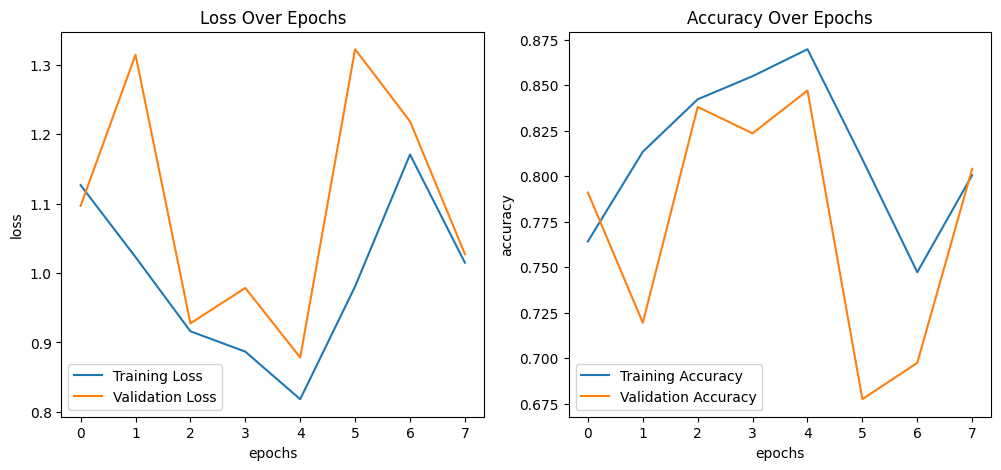


Final Training Loss: 1.0148
Final Validation Loss: 1.0271
Final Training Accuracy: 0.8006
Final Validation Accuracy: 0.8040


In [ ]:
plot_history(history)

In [ ]:
model_rnn_2 = create_rnn_model(vectorize_layer=vectorize_layer,
                               embedding_dim=200,
                               rnn_units=32,
                               num_rnn_layers=2,
                               num_classes=6,
                               seed=seed,
                               dropout_rate=0.3,
                               l2_lambda=0.001
                               )

model_rnn_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 64, 200)           3000000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64, 32)            7456      
                                                                 
 dropout_4 (Dropout)         (None, 64, 32)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                           

In [ ]:
start_time = time.time()

history = model_rnn_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 39s 71ms/step - loss: 1.6560 - accuracy: 0.4865 - val_loss: 1.3409 - val_accuracy: 0.6735
Epoch 2/20
500/500 [==============================] - 47s 95ms/step - loss: 1.1800 - accuracy: 0.7498 - val_loss: 1.1067 - val_accuracy: 0.7855
Epoch 3/20
500/500 [==============================] - 46s 93ms/step - loss: 1.1006 - accuracy: 0.7892 - val_loss: 1.0453 - val_accuracy: 0.8125
Epoch 4/20
500/500 [==============================] - 44s 89ms/step - loss: 0.9682 - accuracy: 0.8338 - val_loss: 1.0245 - val_accuracy: 0.8050
Epoch 5/20
500/500 [==============================] - 52s 105ms/step - loss: 1.1569 - accuracy: 0.7709 - val_loss: 1.6260 - val_accuracy: 0.6105
Epoch 6/20
500/500 [==============================] - 36s 72ms/step - loss: 1.1532 - accuracy: 0.7761 - val_loss: 1.0368 - val_accuracy: 0.8065
Epoch 7/20
500/500 [==============================] - 41s 83ms/step - loss: 0.8940 - accuracy: 0.8478 - val_loss: 0.9670 - val_accuracy

In [ ]:
results_df = evaluate_and_log_model(model_rnn_2, 'Two Layer RNN - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 1s 18ms/step - loss: 0.7969 - accuracy: 0.8490
Test Loss: 0.7969131469726562, Test Accuracy: 0.8489999771118164


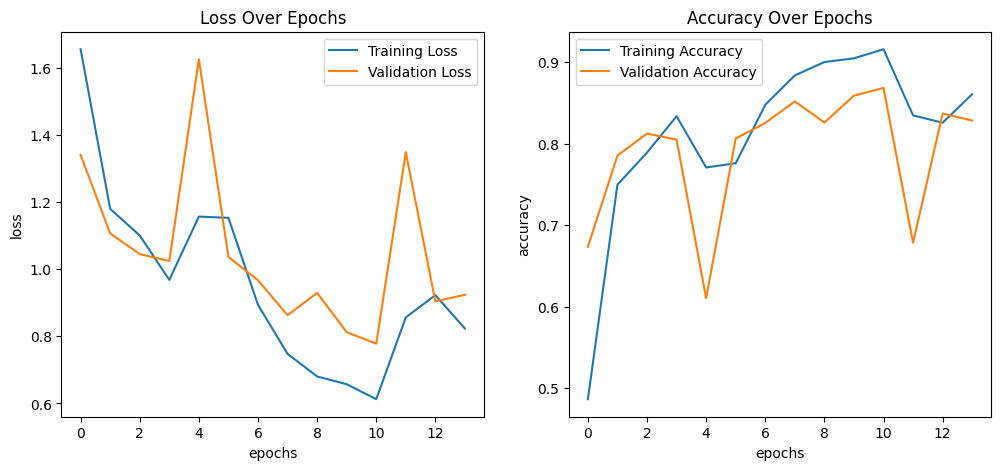


Final Training Loss: 0.8231
Final Validation Loss: 0.9238
Final Training Accuracy: 0.8608
Final Validation Accuracy: 0.8285


In [ ]:
plot_history(history)

In [ ]:
results_df

,model,test_loss,test_accuracy,training_time,n_epochs,avg_epoch_time
0,One Layer RNN,0.723073,0.8105,246.815577,7,35.259368
1,One Layer RNN - Regularised,0.994680,0.8075,287.269851,8,35.908731
2,Two Layer RNN - Regularised,0.796913,0.8490,651.950743,14,46.567910


#### LSTM Models

In [ ]:
model_lstm_1 = create_lstm_model(vectorize_layer=vectorize_layer,
                                 embedding_dim=200,
                                 lstm_units=32,
                                 num_lstm_layers=1,
                                 num_classes=6,
                                 seed=seed,
                                 dropout_rate=0.3,
                                 l2_lambda=0.001)

model_lstm_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 64, 200)           3000000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                29824     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                           

In [ ]:
start_time = time.time()

history = model_lstm_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 49s 90ms/step - loss: 1.5430 - accuracy: 0.4711 - val_loss: 1.3412 - val_accuracy: 0.6125
Epoch 2/20
500/500 [==============================] - 41s 82ms/step - loss: 1.1654 - accuracy: 0.6858 - val_loss: 1.1261 - val_accuracy: 0.7020
Epoch 3/20
500/500 [==============================] - 41s 81ms/step - loss: 1.0030 - accuracy: 0.7442 - val_loss: 0.9997 - val_accuracy: 0.7760
Epoch 4/20
500/500 [==============================] - 41s 81ms/step - loss: 0.9118 - accuracy: 0.8048 - val_loss: 0.9164 - val_accuracy: 0.8165
Epoch 5/20
500/500 [==============================] - 41s 82ms/step - loss: 0.8141 - accuracy: 0.8566 - val_loss: 0.8336 - val_accuracy: 0.8535
Epoch 6/20
500/500 [==============================] - 39s 78ms/step - loss: 0.7810 - accuracy: 0.8804 - val_loss: 0.8093 - val_accuracy: 0.8740
Epoch 7/20
500/500 [==============================] - 38s 75ms/step - loss: 0.7552 - accuracy: 0.8931 - val_loss: 0.8407 - val_accuracy:

In [ ]:
results_df = evaluate_and_log_model(model_lstm_1, 'One Layer LSTM - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 1s 13ms/step - loss: 0.6086 - accuracy: 0.9120
Test Loss: 0.6086408495903015, Test Accuracy: 0.9120000004768372


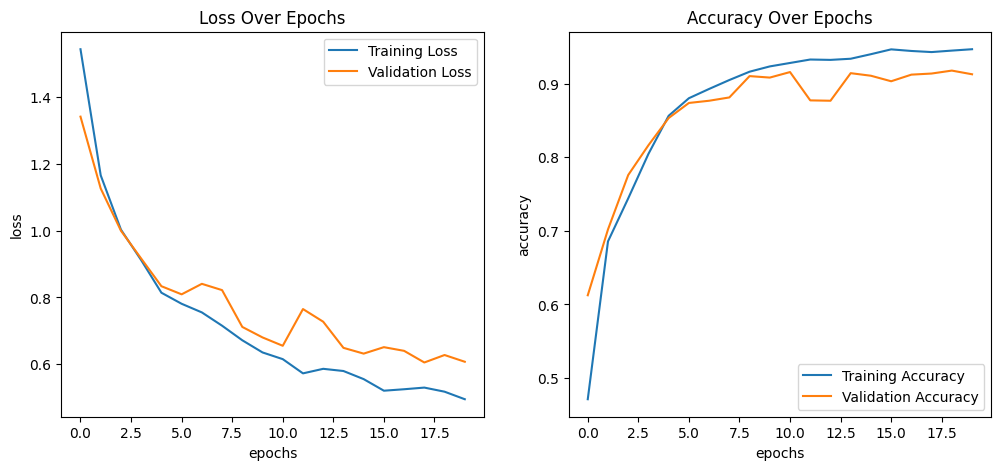


Final Training Loss: 0.4953
Final Validation Loss: 0.6075
Final Training Accuracy: 0.9471
Final Validation Accuracy: 0.9130


In [ ]:
plot_history(history)

In [ ]:
model_lstm_2 = create_lstm_model(vectorize_layer=vectorize_layer,
                               embedding_dim=200,
                               lstm_units=32,
                               num_lstm_layers=2,
                               num_classes=6,
                               seed=seed,
                               dropout_rate=0.3,
                               l2_lambda=0.001)

model_lstm_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 64, 200)           3000000   
                                                                 
 lstm_2 (LSTM)               (None, 64, 32)            29824     
                                                                 
 dropout_2 (Dropout)         (None, 64, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                           

In [ ]:
start_time = time.time()

history = model_lstm_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 69s 122ms/step - loss: 1.6173 - accuracy: 0.4083 - val_loss: 1.3813 - val_accuracy: 0.5870
Epoch 2/20
500/500 [==============================] - 57s 115ms/step - loss: 1.2357 - accuracy: 0.6708 - val_loss: 1.2039 - val_accuracy: 0.6805
Epoch 3/20
500/500 [==============================] - 57s 114ms/step - loss: 1.0292 - accuracy: 0.7722 - val_loss: 0.9716 - val_accuracy: 0.8155
Epoch 4/20
500/500 [==============================] - 59s 119ms/step - loss: 0.8988 - accuracy: 0.8304 - val_loss: 0.8580 - val_accuracy: 0.8550
Epoch 5/20
500/500 [==============================] - 56s 113ms/step - loss: 0.8089 - accuracy: 0.8667 - val_loss: 0.7946 - val_accuracy: 0.8725
Epoch 6/20
500/500 [==============================] - 55s 110ms/step - loss: 0.7432 - accuracy: 0.8869 - val_loss: 0.8395 - val_accuracy: 0.8545
Epoch 7/20
500/500 [==============================] - 55s 110ms/step - loss: 0.6925 - accuracy: 0.9036 - val_loss: 0.8439 - val_ac

In [ ]:
results_df = evaluate_and_log_model(model_lstm_2, 'Two Layer LSTM - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 1s 19ms/step - loss: 0.7827 - accuracy: 0.8725
Test Loss: 0.7826704382896423, Test Accuracy: 0.8725000023841858


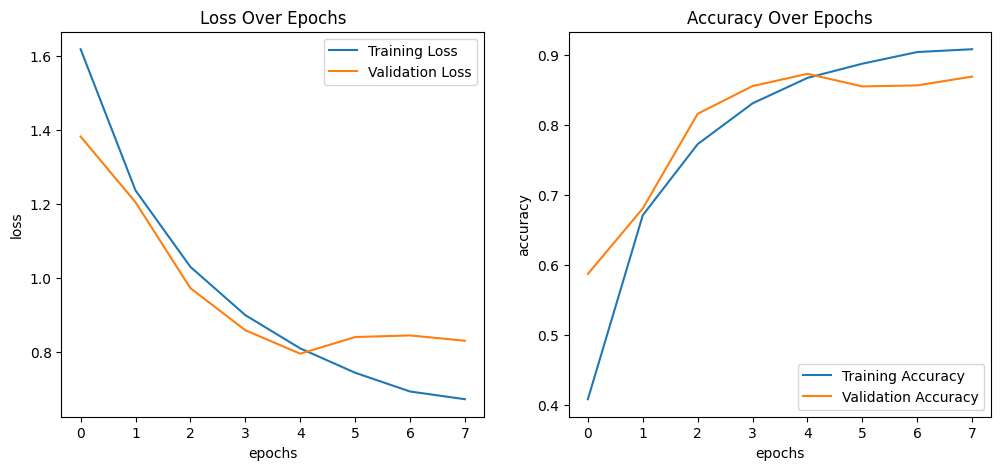


Final Training Loss: 0.6716
Final Validation Loss: 0.8296
Final Training Accuracy: 0.9076
Final Validation Accuracy: 0.8685


In [ ]:
plot_history(history)

In [ ]:
results_df

,model,test_loss,test_accuracy,training_time,n_epochs,avg_epoch_time
0,One Layer RNN,0.723073,0.8105,246.815577,7,35.259368
1,One Layer RNN - Regularised,0.994680,0.8075,287.269851,8,35.908731
2,Two Layer RNN - Regularised,0.796913,0.8490,651.950743,14,46.567910
3,One Layer LSTM - Regularised,0.608641,0.9120,808.006474,20,40.400324
4,Two Layer LSTM - Regularised,0.782670,0.8725,565.473878,8,70.684235


**Modeling First Step: Results**

---
The first step of modeling in which two kind of networks were applied (RNN and LSTM Networks) allowed to obtain a network with very satisfactory performance on the test dataset.

For each of the model a custom Embeddings layer was applied and trained with the following settings:
- vocabulary of 15000 tokens from the training dataset (Top 80% words in terms of frequency)
- the output embeddings dimension equal to 200

The best performing model is a Single Layer LSTM with 32 LSTM neurons in the hidden layer, trained with Dropout Rate on LSTM layer and Classification head with dropout rate set to 30%. Also, model weights during training were regularised with L2 Regularisation with regularisation coefficient (lambda parameter) equal to 0.001. Regularisation significantly helped with preventing overfitting as well as stabilise the training, leading to less radical changes and sudden large jumps/falls of loss among epochs.

The final test accuracy of the model is: **91.2%**
<br><br>
### 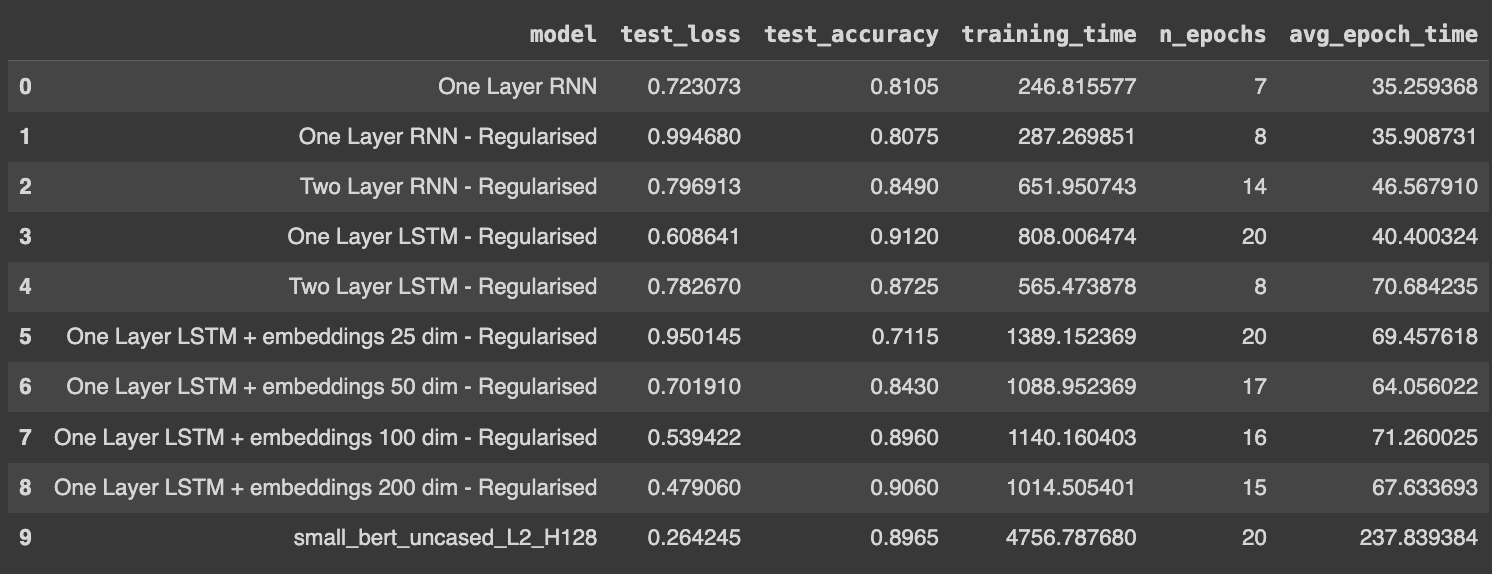**⚠️ important disclaimer about Early Stopping ⚠️**

---
All of the models above were trained with early stopping monitoring validation loss with patience of three epochs. The same or very similar stopping will also be applied in training of all other models in this notebooks, due to two reasons:
- Minimizing the overfitting to training data - the model trainings can stop before models overfit.
- Saving computational resources - Google Colab Free Tier allows less then three hours of GPU connection daily. Not to waste time on calculating epochs that will not have any effect on the project due to overfitting, early stopping can be applie to save time and computational resources.

## Question 2 (30 points)

Now download the pretrained word embedding models from Gensim library with different embedding size 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200'. Show the most similar words for `anger, fear, joy, love, sadness, and surprise`. Use the best performing model from the Quesetion 1 and replace the embedding layer with pretrained word embeddings with different embedding size. Explain whether these pretrained embedding would imporve the model performance.


In [ ]:
import gensim.downloader as api
# Show all available models in gensim-data
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
words_list = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

emb_model = api.load('glove-twitter-200')

similaritiesDF = pd.DataFrame(columns=['word', 'similar_1', 'similar_2', 'similar_3'])

for word in words_list:

    similarities = emb_model.most_similar(word)

    word_data = [[
        word,
        similarities[0][0],
        similarities[1][0],
        similarities[2][0]
    ]]

    similaritiesDF = pd.concat([similaritiesDF,
                                pd.DataFrame(columns=['word', 'similar_1', 'similar_2', 'similar_3'], data=word_data)])

    similaritiesDF.reset_index(drop=True, inplace=True)


similaritiesDF.set_index('word')


[==================================================] 100.0% 758.5/758.5MB downloaded


,similar_1,similar_2,similar_3
word,,,
anger,frustration,hatred,sadness
fear,afraid,fears,faith
joy,happiness,grace,pleasure
love,you,much,always
sadness,happiness,pain,sorrow
surprise,suprise,surprises,special


#### Model + Embeddings creation function

In [ ]:
epochs=20

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

#### LSTM (1 layer) + Embeddings (glove-twitter-25)

In [ ]:
lstm_embeddings_0 = create_lstm_model_with_embeddings(vectorize_layer,
                                                      embedding_dim=25,
                                                      lstm_units=128,
                                                      num_lstm_layers=1,
                                                      num_classes=6,
                                                      embeddings_path='glove-twitter-25',
                                                      seed=seed,
                                                      dropout_rate=0.3,
                                                      l2_lambda=0.001
                                                      )

lstm_embeddings_0.summary()

[==================================================] 100.0% 104.8/104.8MB downloaded
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 64, 25)            375000    
                                                                 
 lstm_4 (LSTM)               (None, 128)               78848     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)  

In [ ]:
start_time = time.time()

history = lstm_embeddings_0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping],
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 51s 96ms/step - loss: 1.5383 - accuracy: 0.4481 - val_loss: 1.4061 - val_accuracy: 0.4910
Epoch 2/20
500/500 [==============================] - 47s 93ms/step - loss: 1.3620 - accuracy: 0.5102 - val_loss: 1.3038 - val_accuracy: 0.5325
Epoch 3/20
500/500 [==============================] - 44s 89ms/step - loss: 1.2852 - accuracy: 0.5359 - val_loss: 1.2437 - val_accuracy: 0.5425
Epoch 4/20
500/500 [==============================] - 45s 90ms/step - loss: 1.2191 - accuracy: 0.5670 - val_loss: 1.1856 - val_accuracy: 0.5705
Epoch 5/20
500/500 [==============================] - 45s 90ms/step - loss: 1.1757 - accuracy: 0.5898 - val_loss: 1.1402 - val_accuracy: 0.5955
Epoch 6/20
500/500 [==============================] - 45s 89ms/step - loss: 1.1328 - accuracy: 0.6099 - val_loss: 1.1044 - val_accuracy: 0.6205
Epoch 7/20
500/500 [==============================] - 49s 97ms/step - loss: 1.1011 - accuracy: 0.6254 - val_loss: 1.0720 - val_accuracy:

In [ ]:

results_df = evaluate_and_log_model(lstm_embeddings_0, 'One Layer LSTM + embeddings 25 dim - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 2s 25ms/step - loss: 0.9501 - accuracy: 0.7115
Test Loss: 0.9501454830169678, Test Accuracy: 0.7114999890327454


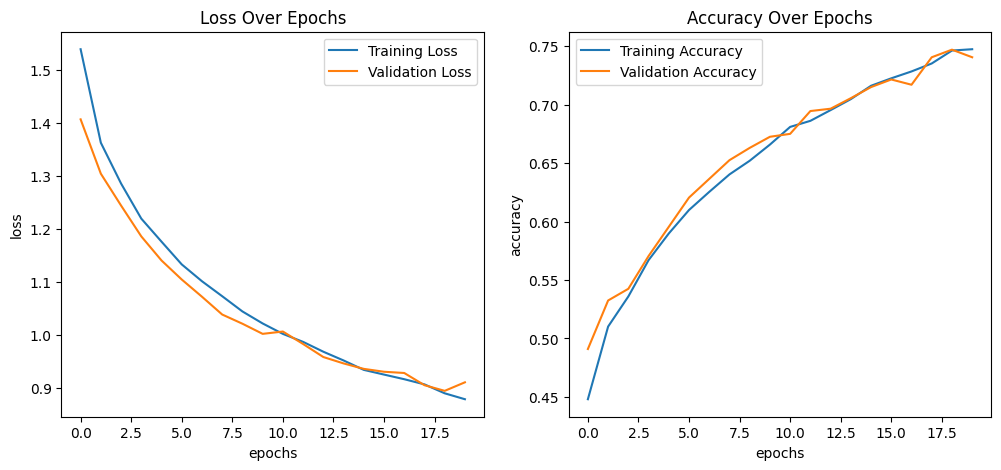


Final Training Loss: 0.8789
Final Validation Loss: 0.9107
Final Training Accuracy: 0.7474
Final Validation Accuracy: 0.7405


In [ ]:
plot_history(history)

#### LSTM (1 layer) + Embeddings (glove-twitter-50)

In [ ]:
lstm_embeddings_1 = create_lstm_model_with_embeddings(vectorize_layer,
                                                      embedding_dim=50,
                                                      lstm_units=128,
                                                      num_lstm_layers=1,
                                                      num_classes=6,
                                                      embeddings_path='glove-twitter-50',
                                                      seed=seed,
                                                      dropout_rate=0.3,
                                                      l2_lambda=0.001)

lstm_embeddings_1.summary()

[==================================================] 100.0% 199.5/199.5MB downloaded
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 64, 50)            750000    
                                                                 
 lstm_5 (LSTM)               (None, 128)               91648     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 6)  

In [ ]:
start_time = time.time()

history = lstm_embeddings_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping],
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 53s 99ms/step - loss: 1.4974 - accuracy: 0.4729 - val_loss: 1.2966 - val_accuracy: 0.5395
Epoch 2/20
500/500 [==============================] - 48s 95ms/step - loss: 1.2361 - accuracy: 0.5844 - val_loss: 1.1280 - val_accuracy: 0.6340
Epoch 3/20
500/500 [==============================] - 47s 94ms/step - loss: 1.0952 - accuracy: 0.6541 - val_loss: 1.0280 - val_accuracy: 0.6835
Epoch 4/20
500/500 [==============================] - 48s 97ms/step - loss: 1.0059 - accuracy: 0.6954 - val_loss: 0.9747 - val_accuracy: 0.6930
Epoch 5/20
500/500 [==============================] - 46s 91ms/step - loss: 0.9431 - accuracy: 0.7222 - val_loss: 0.9163 - val_accuracy: 0.7290
Epoch 6/20
500/500 [==============================] - 46s 92ms/step - loss: 0.8890 - accuracy: 0.7449 - val_loss: 0.8565 - val_accuracy: 0.7505
Epoch 7/20
500/500 [==============================] - 48s 96ms/step - loss: 0.8583 - accuracy: 0.7625 - val_loss: 0.8620 - val_accuracy:

In [ ]:

results_df = evaluate_and_log_model(lstm_embeddings_1, 'One Layer LSTM + embeddings 50 dim - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 2s 32ms/step - loss: 0.7019 - accuracy: 0.8430
Test Loss: 0.7019097208976746, Test Accuracy: 0.8429999947547913


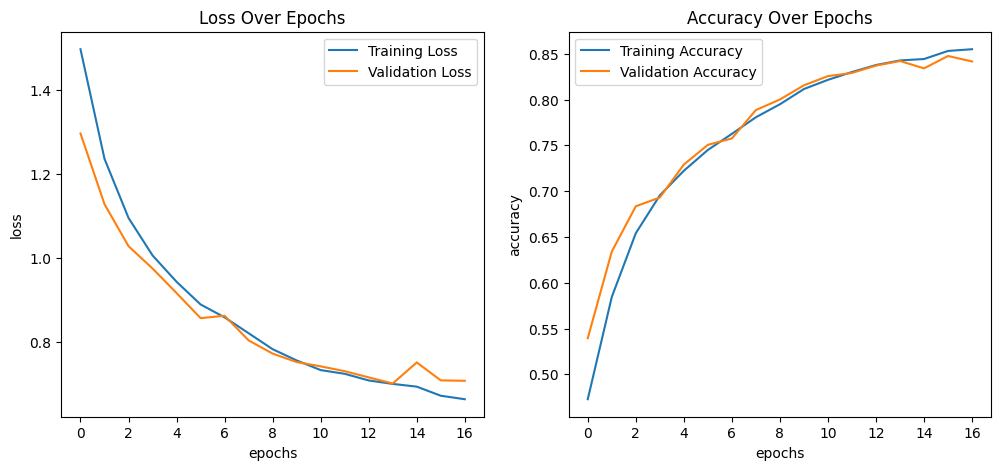


Final Training Loss: 0.6632
Final Validation Loss: 0.7071
Final Training Accuracy: 0.8549
Final Validation Accuracy: 0.8415


In [ ]:
plot_history(history)

#### LSTM (1 layers) + Embeddings (glove-twitter-100)

In [ ]:
lstm_embeddings_2 = create_lstm_model_with_embeddings(vectorize_layer,
                                                      embedding_dim=100,
                                                      lstm_units=128,
                                                      num_lstm_layers=1,
                                                      num_classes=6,
                                                      embeddings_path='glove-twitter-100',
                                                      seed=seed,
                                                      dropout_rate=0.3,
                                                      l2_lambda=0.001)

lstm_embeddings_2.summary()

[==================================================] 100.0% 387.1/387.1MB downloaded
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 64, 100)           1500000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)  

In [ ]:
start_time = time.time()

history = lstm_embeddings_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping],
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 59s 112ms/step - loss: 1.4188 - accuracy: 0.5339 - val_loss: 1.0925 - val_accuracy: 0.6700
Epoch 2/20
500/500 [==============================] - 52s 105ms/step - loss: 0.9796 - accuracy: 0.7129 - val_loss: 0.8404 - val_accuracy: 0.7715
Epoch 3/20
500/500 [==============================] - 53s 105ms/step - loss: 0.8137 - accuracy: 0.7821 - val_loss: 0.7345 - val_accuracy: 0.8155
Epoch 4/20
500/500 [==============================] - 53s 106ms/step - loss: 0.7130 - accuracy: 0.8289 - val_loss: 0.6745 - val_accuracy: 0.8525
Epoch 5/20
500/500 [==============================] - 56s 111ms/step - loss: 0.6595 - accuracy: 0.8487 - val_loss: 0.6068 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 55s 109ms/step - loss: 0.6085 - accuracy: 0.8708 - val_loss: 0.5768 - val_accuracy: 0.8830
Epoch 7/20
500/500 [==============================] - 53s 106ms/step - loss: 0.5811 - accuracy: 0.8800 - val_loss: 0.5539 - val_ac

In [ ]:

results_df = evaluate_and_log_model(lstm_embeddings_2, 'One Layer LSTM + embeddings 100 dim - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 2s 29ms/step - loss: 0.5394 - accuracy: 0.8960
Test Loss: 0.5394216179847717, Test Accuracy: 0.8960000276565552


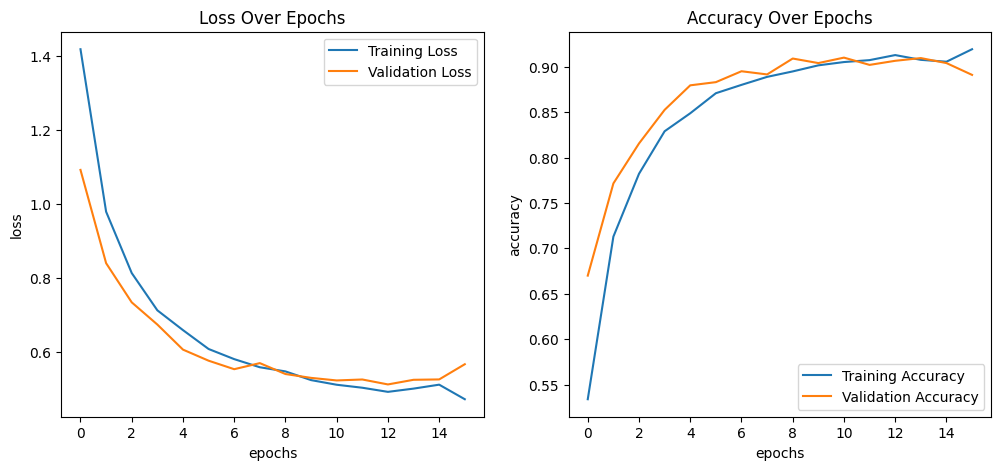


Final Training Loss: 0.4727
Final Validation Loss: 0.5673
Final Training Accuracy: 0.9193
Final Validation Accuracy: 0.8910


In [ ]:
plot_history(history)

#### LSTM (1 layer) + Embeddings (glove-twitter-200)

In [ ]:
lstm_embeddings_3 = create_lstm_model_with_embeddings(vectorize_layer,
                                                      embedding_dim=200,
                                                      lstm_units=128,
                                                      num_lstm_layers=1,
                                                      num_classes=6,
                                                      embeddings_path='glove-twitter-200',
                                                      seed=seed,
                                                      dropout_rate=0.3,
                                                      l2_lambda=0.001)

lstm_embeddings_3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, 64, 200)           3000000   
                                                                 
 lstm_7 (LSTM)               (None, 128)               168448    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                           

In [ ]:
start_time = time.time()

history = lstm_embeddings_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping],
)

end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 62s 116ms/step - loss: 1.3667 - accuracy: 0.5826 - val_loss: 0.9438 - val_accuracy: 0.7450
Epoch 2/20
500/500 [==============================] - 57s 114ms/step - loss: 0.8395 - accuracy: 0.7889 - val_loss: 0.7041 - val_accuracy: 0.8380
Epoch 3/20
500/500 [==============================] - 57s 114ms/step - loss: 0.6668 - accuracy: 0.8561 - val_loss: 0.6172 - val_accuracy: 0.8800
Epoch 4/20
500/500 [==============================] - 56s 113ms/step - loss: 0.5816 - accuracy: 0.8850 - val_loss: 0.5593 - val_accuracy: 0.8925
Epoch 5/20
500/500 [==============================] - 59s 117ms/step - loss: 0.5315 - accuracy: 0.8957 - val_loss: 0.5316 - val_accuracy: 0.9035
Epoch 6/20
500/500 [==============================] - 56s 113ms/step - loss: 0.5159 - accuracy: 0.9041 - val_loss: 0.5226 - val_accuracy: 0.9005
Epoch 7/20
500/500 [==============================] - 57s 115ms/step - loss: 0.4846 - accuracy: 0.9116 - val_loss: 0.4891 - val_ac

In [ ]:
results_df = evaluate_and_log_model(lstm_embeddings_3, 'One Layer LSTM + embeddings 200 dim - Regularised', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 2s 33ms/step - loss: 0.4791 - accuracy: 0.9060
Test Loss: 0.47906002402305603, Test Accuracy: 0.906000018119812


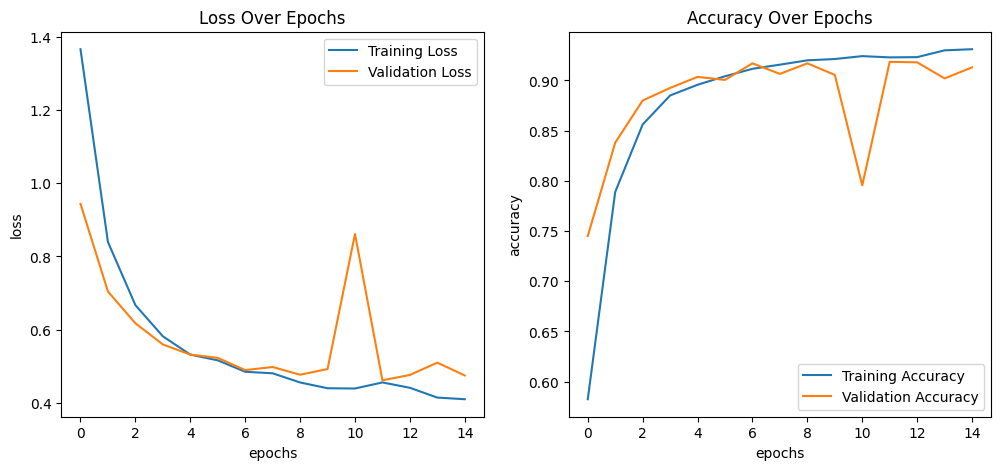


Final Training Loss: 0.4095
Final Validation Loss: 0.4745
Final Training Accuracy: 0.9311
Final Validation Accuracy: 0.9130


In [ ]:
plot_history(history)

In [ ]:
results_df

,model,test_loss,test_accuracy,training_time,n_epochs,avg_epoch_time
0,One Layer RNN,0.723073,0.8105,246.815577,7,35.259368
1,One Layer RNN - Regularised,0.994680,0.8075,287.269851,8,35.908731
2,Two Layer RNN - Regularised,0.796913,0.8490,651.950743,14,46.567910
3,One Layer LSTM - Regularised,0.608641,0.9120,808.006474,20,40.400324
4,Two Layer LSTM - Regularised,0.782670,0.8725,565.473878,8,70.684235
5,One Layer LSTM + embeddings 25 dim - Regularised,0.950145,0.7115,1389.152369,20,69.457618
6,One Layer LSTM + embeddings 50 dim - Regularised,0.701910,0.8430,1088.952369,17,64.056022
7,One Layer LSTM + embeddings 100 dim - Regularised,0.539422,0.8960,1140.160403,16,71.260025
8,One Layer LSTM + embeddings 200 dim - Regularised,0.479060,0.9060,1014.505401,15,67.633693


In [ ]:
results_df.to_csv('model_results_table.csv')

**Pre-trained embeddings: conclusions**

---
1. Pre-trained embeddings (non-trainable) when applied, did not cause better test accuracy than models with 200-dimensional embeddings trained on the available train dataset alone.
2. Lower tier of dimensions of the pre-trained embeddings (glove-twitter-25 and glove-twitter-50) took many epochs to start converging, whereas higher-tier of dimesions of pre-trained embeddings (glove-twitter-100 and glove-twitter-200) quickly achieved accuracy similar to the one achieved by the top performing LSTM model, but did not surpass it.
3. Surprisingly, the training time of the models with pre-trained embeddings was significantly longer, even despite the fact of lower number of trainable parameters (caused by embeddings training set to False). The baseline model took on average 47s per epoch, whereas the training time of the model implementing pre-trained embeddings took between 64 and 71s. This however, could also be caused by unstable access to Google Colab computational resources on the Free Tier. Hence, the results regarding training time should be interpreted with a grain of salt.

It seems that for the given task training 200 dimensional word embeddings on the corpus of words available in the training dataset (15.000 words), cause the classification model to outperform other models that implement state-of-the-art pre-trained embeddings (GloVe). This may mean two things:
- The defualt version of GloVe embeddings is not enough to significantly surpass the performance of the same model with custom trained embeddings.
- The test dataset is limited to contain vocabulary very similar to the one from training data, hence embeddings trained on the training dataset work better than GloVe.


## Question 3 (20 points)

Now load BERT models from TensorFlow Hub. Fine-tune it with the data and evaluate the model performance. Check how you can do it [here](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### BERT Fine-Tuning

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model(n_labels=2, seed=42):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1, seed=seed)(net)
    net = tf.keras.layers.Dense(n_labels, activation='softmax', name='classifier',
                                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(net)
    return tf.keras.Model(text_input, net)

In [ ]:
def compile_bert_model(model, num_train_steps, num_warmup_steps):
      init_lr = 3e-5
      optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

      model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      return model

In [ ]:
epochs = 20

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

bert_model_1 = build_classifier_model(n_labels=6, seed=seed)

bert_model_1 = compile_bert_model(bert_model_1,
                                  num_train_steps=num_train_steps,
                                  num_warmup_steps=num_warmup_steps)

In [ ]:
bert_model_1.count_params()

4386695

In [ ]:
start_time = time.time()


history = bert_model_1.fit(x=train_ds,
                           validation_data=val_ds,
                           epochs=epochs,
                           callbacks=[early_stopping])


end_time = time.time()

time_delta = end_time - start_time

train_epochs = len(history.history['loss'])

Epoch 1/20
500/500 [==============================] - 230s 454ms/step - loss: 1.7201 - accuracy: 0.3039 - val_loss: 1.5373 - val_accuracy: 0.4210
Epoch 2/20
500/500 [==============================] - 218s 435ms/step - loss: 1.4094 - accuracy: 0.4623 - val_loss: 1.0102 - val_accuracy: 0.6450
Epoch 3/20
500/500 [==============================] - 213s 427ms/step - loss: 0.8553 - accuracy: 0.7028 - val_loss: 0.5842 - val_accuracy: 0.8125
Epoch 4/20
500/500 [==============================] - 209s 417ms/step - loss: 0.5593 - accuracy: 0.8190 - val_loss: 0.4355 - val_accuracy: 0.8580
Epoch 5/20
500/500 [==============================] - 206s 412ms/step - loss: 0.4287 - accuracy: 0.8558 - val_loss: 0.3795 - val_accuracy: 0.8745
Epoch 6/20
500/500 [==============================] - 209s 417ms/step - loss: 0.3658 - accuracy: 0.8762 - val_loss: 0.3422 - val_accuracy: 0.8795
Epoch 7/20
500/500 [==============================] - 211s 422ms/step - loss: 0.3192 - accuracy: 0.8882 - val_loss: 0.3217 -

In [ ]:
results_df = evaluate_and_log_model(bert_model_1, 'small_bert_uncased_L2_H128', test_ds, time_delta, train_epochs, model_registry=results_df)

63/63 [==============================] - 7s 113ms/step - loss: 0.2642 - accuracy: 0.8965
Test Loss: 0.264244943857193, Test Accuracy: 0.8964999914169312
63/63 [==============================] - 7s 111ms/step - loss: 0.2642 - accuracy: 0.8965
Test Loss: 0.264244943857193, Test Accuracy: 0.8964999914169312


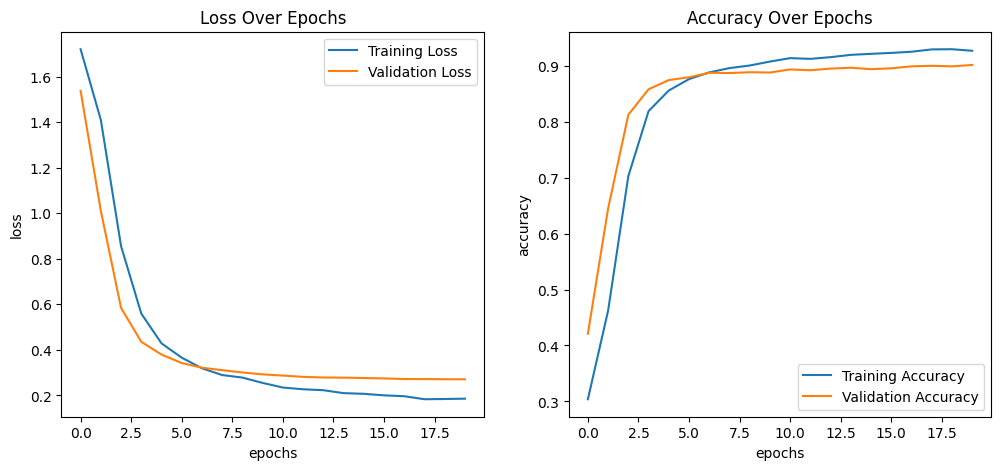


Final Training Loss: 0.1859
Final Validation Loss: 0.2709
Final Training Accuracy: 0.9269
Final Validation Accuracy: 0.9015


In [ ]:
plot_history(history)

In [ ]:
results_df.to_csv('model_results_table.csv')

In [ ]:
results_df

,model,test_loss,test_accuracy,training_time,n_epochs,avg_epoch_time
0,One Layer RNN,0.723073,0.8105,246.815577,7,35.259368
1,One Layer RNN - Regularised,0.994680,0.8075,287.269851,8,35.908731
2,Two Layer RNN - Regularised,0.796913,0.8490,651.950743,14,46.567910
3,One Layer LSTM - Regularised,0.608641,0.9120,808.006474,20,40.400324
4,Two Layer LSTM - Regularised,0.782670,0.8725,565.473878,8,70.684235
5,One Layer LSTM + embeddings 25 dim - Regularised,0.950145,0.7115,1389.152369,20,69.457618
6,One Layer LSTM + embeddings 50 dim - Regularised,0.701910,0.8430,1088.952369,17,64.056022
7,One Layer LSTM + embeddings 100 dim - Regularised,0.539422,0.8960,1140.160403,16,71.260025
8,One Layer LSTM + embeddings 200 dim - Regularised,0.479060,0.9060,1014.505401,15,67.633693
9,small_bert_uncased_L2_H128,0.264245,0.8965,4756.787680,20,237.839384


**Transfer Learning with Bert Model: conclusions**

---
To achieve higher accuracy, BERT model was trained. However, small and computationally efficient variant of SMALL BERT was choosen due to Google Colab limitations. The choosen model contains of:
- 2 Transformer Layers
- 128 hidden nodes per hidden layer
- 2 attention heads per hidden layer

The model is computationall efficient, however, can achieve worse results than its more complex variants.

During the 20-epoch long training, the model very quckly started achieving high validation accuracy of around 88% after 5 epochs. However, its final accuracy did not surpass the one of the One-Layer LSTM Model with custom 200-dimensional embeddings and training regularisation applied.

The final accuracy of the BERT implementation was: 89.65%.

It is also important to mention significant increase in training time which took in total 4756 seconds (80 minutes) with the average of 238 seconds (4 minutes) per epoch. Massive increase in training time as well as lower test accuracy achieves indicate that implementation of SMALL BERT in this contet is not better then previously mentioned LSTM implementation. However, if more computational resoursces were available, it would be worthwile training other, larger variants of BERT which might achieve better results and surpass currently best performing model.

# Question 4 (10 points)

Now let's try some state-of-the-art Large Language Models (LLM)! Cohere provides trial API for free and you may register and use the LLM. After you obtain the trial API, go to https://dashboard.cohere.com/playground/classify and see how the LLM-based classification works. You could choose several pretrained embedding models such as embed-engligh-2.0 or embed-engligh-3.0 and provide example training data. Evaluate the model performance.

In [ ]:
cohere_api_key = "xxxxx"

#### Creation of Classification Examples

In [ ]:
import cohere
from cohere import ClassifyExample

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
# Define the emotion labels
emotion_labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
label_to_text = {v: k for k, v in emotion_labels.items()}  # Reverse mapping for predictions

# Select random examples from the train subset for each emotion
examples = []
for label_id, label_name in emotion_labels.items():
    # Filter the dataset for the current label
    label_data = emotion['train'].filter(lambda x: x['label'] == label_id)
    # Randomly select examples
    examples_raw = random.choices(label_data, k=100)
    # Add the examples to the examples list
    for e in examples_raw:
        examples.append(ClassifyExample(text=e['text'], label=label_name))

co = cohere.Client(cohere_api_key)

#### Checking if it works

In [ ]:
K = 5  # You can change this value to classify a different number of samples

# Select K random samples from the test subset
test_samples = random.sample(list(emotion['test']), K)
inputs = [sample['text'] for sample in test_samples]

# Perform the classification
response = co.classify(
    model="large",
    inputs=inputs,
    examples=examples
)

# Print the results
for idx, classification in enumerate(response.classifications):
    print(f"Input: {inputs[idx]}")
    print(f"Predicted Label: {classification.prediction}")
    print(f"Confidence: {classification.confidence}\n")

Input: i didnt make it to my weight watchers meeting feeling guilty i made sure i had a healthy breakfast consisting of museli yoghurt and fruit
Predicted Label: anger
Confidence: 0.36431575

Input: i feel like i cant have dirty dishes piled up laundry strewn about or toys scattered everywhere
Predicted Label: anger
Confidence: 0.9981754

Input: i feel that i worry too much and much on petty things like
Predicted Label: fear
Confidence: 0.861844

Input: i could feel how much slower i was on the treadmill but the pace was pleasant and after six days of relative inactivity i was just happy to be running again
Predicted Label: surprise
Confidence: 0.9061938

Input: i think i was also having a pity party because i am feeling a bit frustrated with how little time i seem to have each day
Predicted Label: anger
Confidence: 0.9956376



#### Classification of the Test Dataset

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating 2000 predictions based on 300 training examples (few-show learning).
Batch 0 / 40
Batch 1 / 40
Batch 2 / 40
Batch 3 / 40
Batch 4 / 40
Batch 5 / 40
Batch 6 / 40
Batch 7 / 40
Batch 8 / 40
Batch 9 / 40
Batch 10 / 40
Batch 11 / 40
Batch 12 / 40
Batch 13 / 40
Batch 14 / 40
Batch 15 / 40
Batch 16 / 40
Batch 17 / 40
Batch 18 / 40
Batch 19 / 40
Batch 20 / 40
Batch 21 / 40
Batch 22 / 40
Batch 23 / 40
Batch 24 / 40
Batch 25 / 40
Batch 26 / 40
Batch 27 / 40
Batch 28 / 40
Batch 29 / 40
Batch 30 / 40
Batch 31 / 40
Batch 32 / 40
Batch 33 / 40
Batch 34 / 40
Batch 35 / 40
Batch 36 / 40
Batch 37 / 40
Batch 38 / 40
Batch 39 / 40


Performance Metrics: 
--------------------
Accuracy: 0.5525
Precision: 0.5096136175777042
Recall: 0.5907732696926867





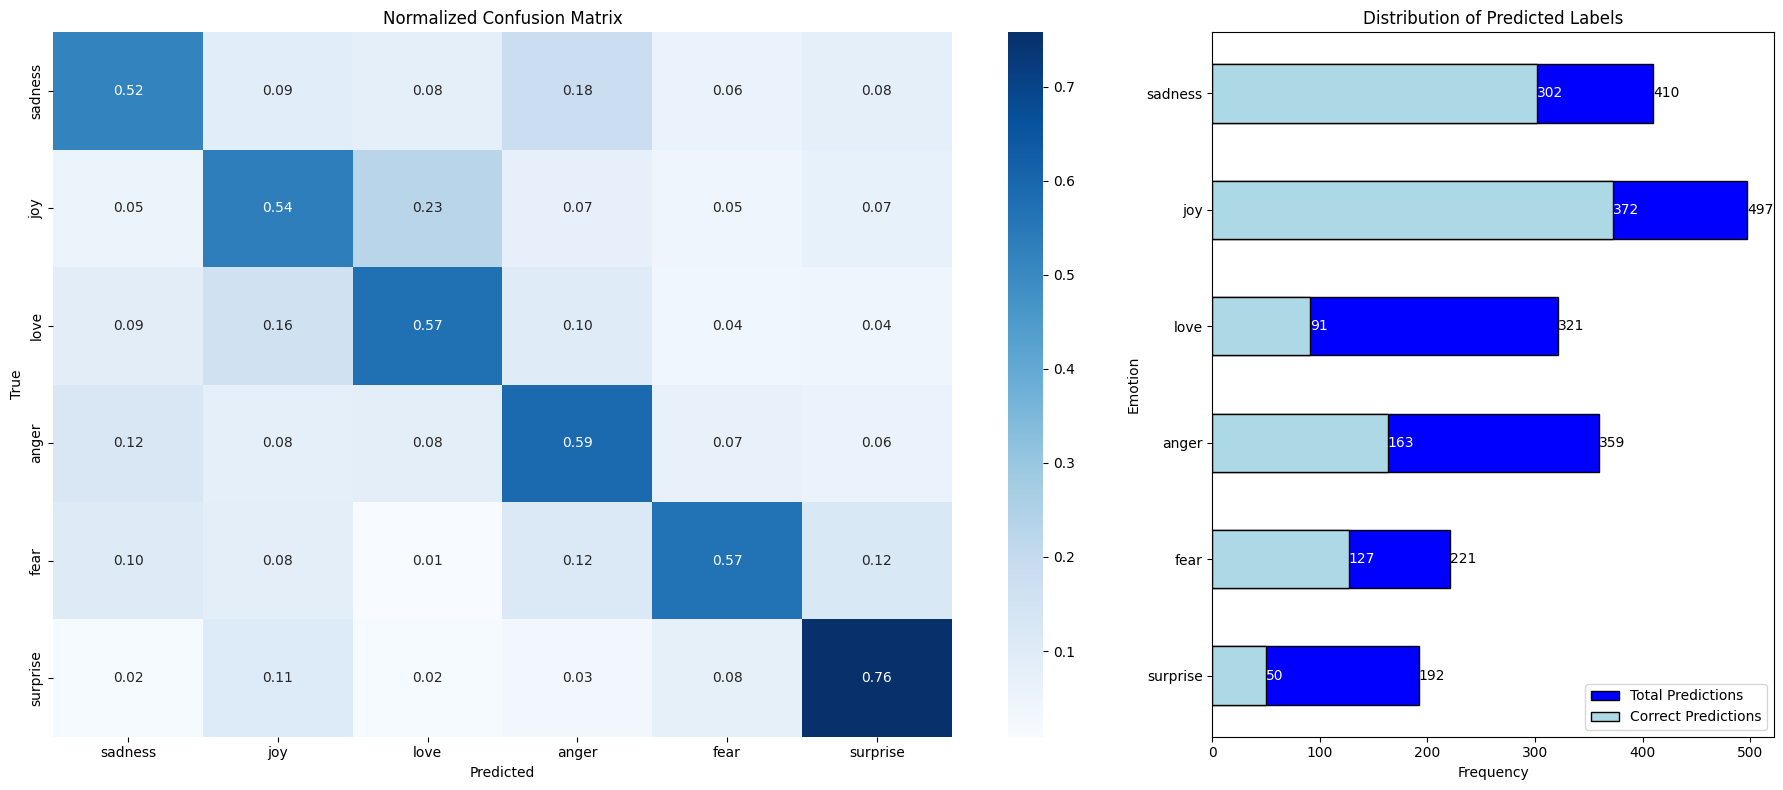


Time of execution: 153.66523432731628 seconds


In [ ]:
classify_emotions(cohere_api_key, emotion['train'], emotion['test'], batch_size=50, num_examples_per_class=50, display_samples=False, model = 'embed-english-v3.0')

Generating 2000 predictions based on 600 training examples (few-show learning).


Model: embed-english-v3.0


Batch 1 / 40
Batch 2 / 40
Batch 3 / 40
Batch 4 / 40
Batch 5 / 40
Batch 6 / 40
Batch 7 / 40
Batch 8 / 40
Batch 9 / 40
Batch 10 / 40
Batch 11 / 40
Batch 12 / 40
Batch 13 / 40
Batch 14 / 40
Batch 15 / 40
Batch 16 / 40
Batch 17 / 40
Batch 18 / 40
Batch 19 / 40
Batch 20 / 40
Batch 21 / 40
Batch 22 / 40
Batch 23 / 40
Batch 24 / 40
Batch 25 / 40
Batch 26 / 40
Batch 27 / 40
Batch 28 / 40
Batch 29 / 40
Batch 30 / 40
Batch 31 / 40
Batch 32 / 40
Batch 33 / 40
Batch 34 / 40
Batch 35 / 40
Batch 36 / 40
Batch 37 / 40
Batch 38 / 40
Batch 39 / 40
Batch 40 / 40


Performance Metrics: 
--------------------
Accuracy: 0.5835
Precision: 0.5411865744033898
Recall: 0.620243119461558





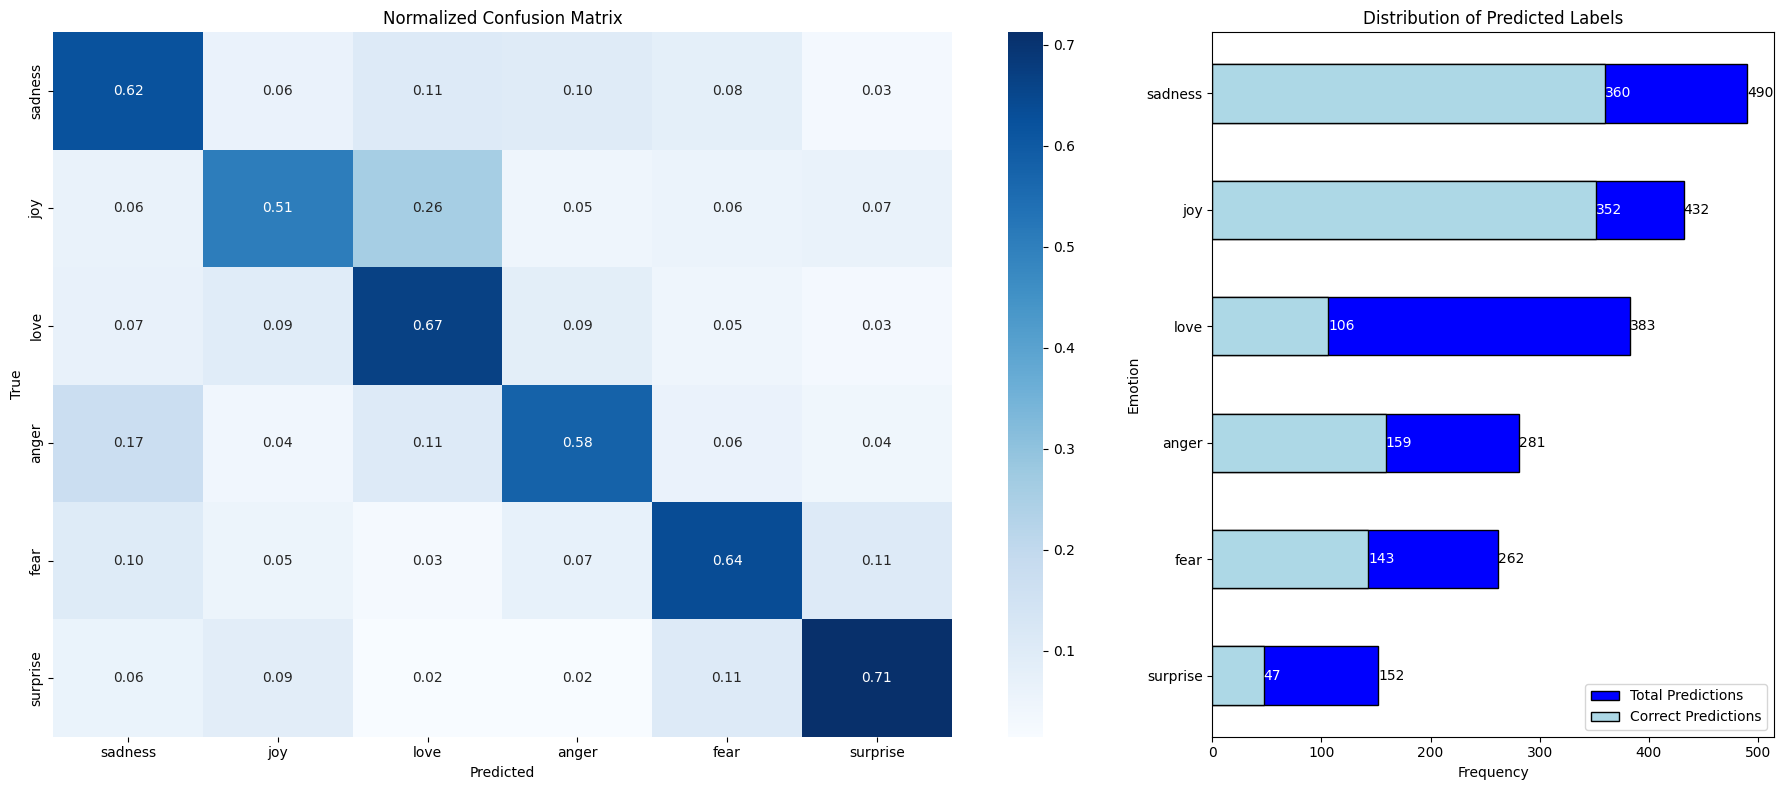


Time of execution: 291.85350918769836 seconds


In [ ]:
classify_emotions(cohere_api_key, emotion['train'], emotion['test'], batch_size=50, num_examples_per_class=100, display_samples=False, model = 'embed-english-v3.0')

Generating 2000 predictions based on 1200 training examples (few-show learning).


Model: embed-english-v3.0


Batch 1 / 40
Batch 2 / 40
Batch 3 / 40
Batch 4 / 40
Batch 5 / 40
Batch 6 / 40
Batch 7 / 40
Batch 8 / 40
Batch 9 / 40
Batch 10 / 40
Batch 11 / 40
Batch 12 / 40
Batch 13 / 40
Batch 14 / 40
Batch 15 / 40
Batch 16 / 40
Batch 17 / 40
Batch 18 / 40
Batch 19 / 40
Batch 20 / 40
Batch 21 / 40
Batch 22 / 40
Batch 23 / 40
Batch 24 / 40
Batch 25 / 40
Batch 26 / 40
Batch 27 / 40
Batch 28 / 40
Batch 29 / 40
Batch 30 / 40
Batch 31 / 40
Batch 32 / 40
Batch 33 / 40
Batch 34 / 40
Batch 35 / 40
Batch 36 / 40
Batch 37 / 40
Batch 38 / 40
Batch 39 / 40
Batch 40 / 40


Performance Metrics: 
--------------------
Accuracy: 0.6375
Precision: 0.5767871011399505
Recall: 0.6606734401967183





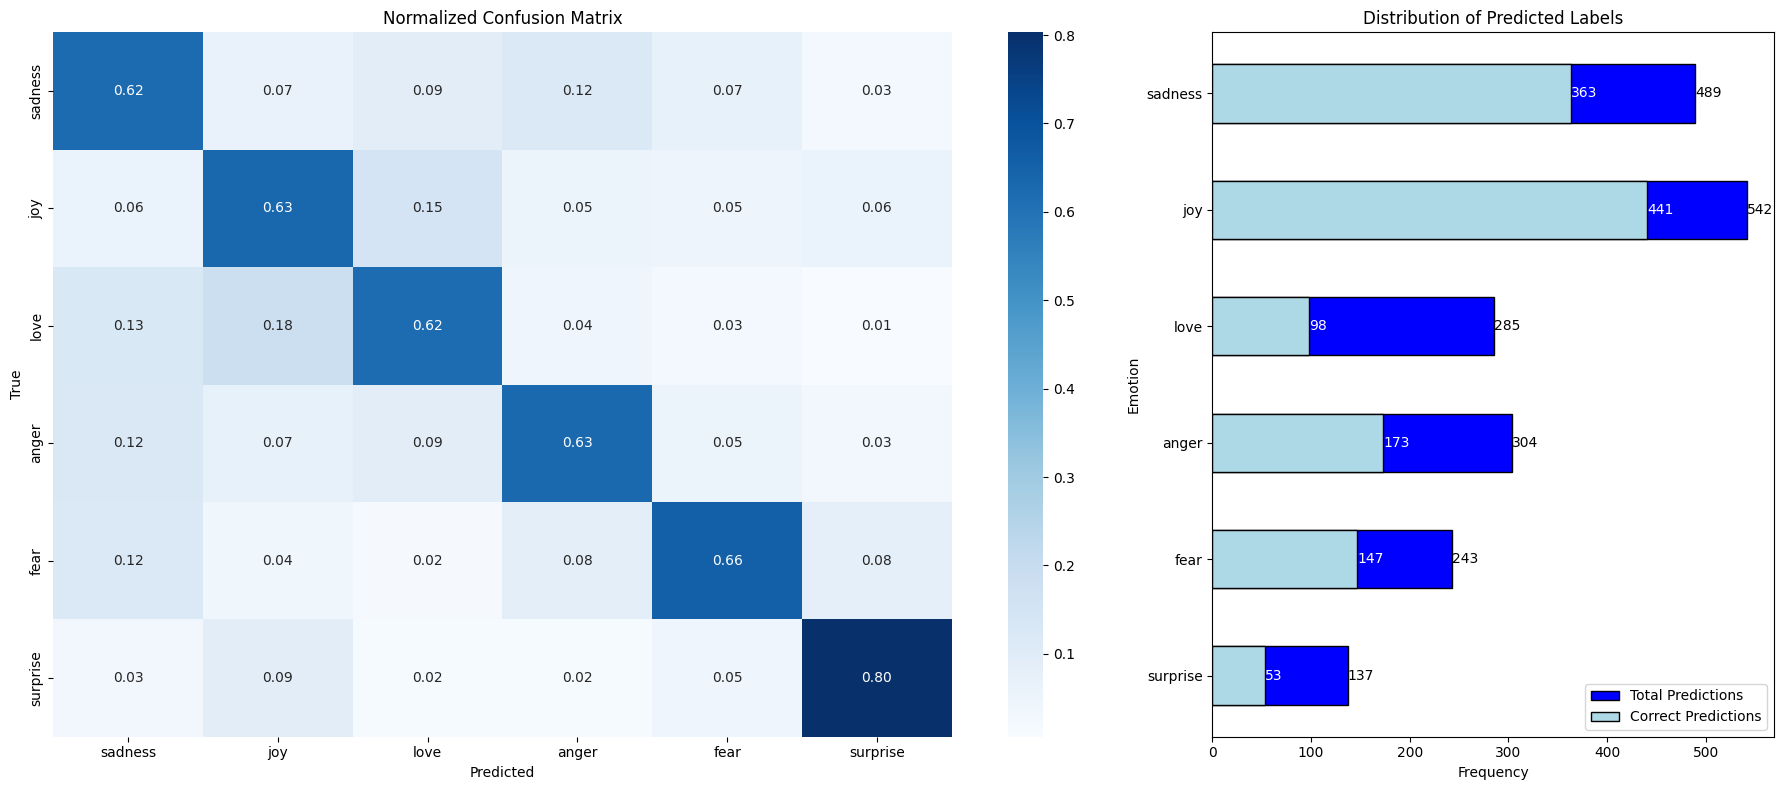


Time of execution: 572.550309419632 seconds


In [ ]:
classify_emotions(cohere_api_key, emotion['train'], emotion['test'], batch_size=50, num_examples_per_class=200, display_samples=False, model = 'embed-english-v3.0')

Generating 2000 predictions based on 2400 training examples (few-show learning).


Model: embed-english-v3.0


Batch 1 / 40
Batch 2 / 40
Batch 3 / 40
Batch 4 / 40
Batch 5 / 40
Batch 6 / 40
Batch 7 / 40
Batch 8 / 40
Batch 9 / 40
Batch 10 / 40
Batch 11 / 40
Batch 12 / 40
Batch 13 / 40
Batch 14 / 40
Batch 15 / 40
Batch 16 / 40
Batch 17 / 40
Batch 18 / 40
Batch 19 / 40
Batch 20 / 40
Batch 21 / 40
Batch 22 / 40
Batch 23 / 40
Batch 24 / 40
Batch 25 / 40
Batch 26 / 40
Batch 27 / 40
Batch 28 / 40
Batch 29 / 40
Batch 30 / 40
Batch 31 / 40
Batch 32 / 40
Batch 33 / 40
Batch 34 / 40
Batch 35 / 40
Batch 36 / 40
Batch 37 / 40
Batch 38 / 40
Batch 39 / 40
Batch 40 / 40


Performance Metrics: 
--------------------
Accuracy: 0.6565
Precision: 0.5883369284232937
Recall: 0.6694947159908019





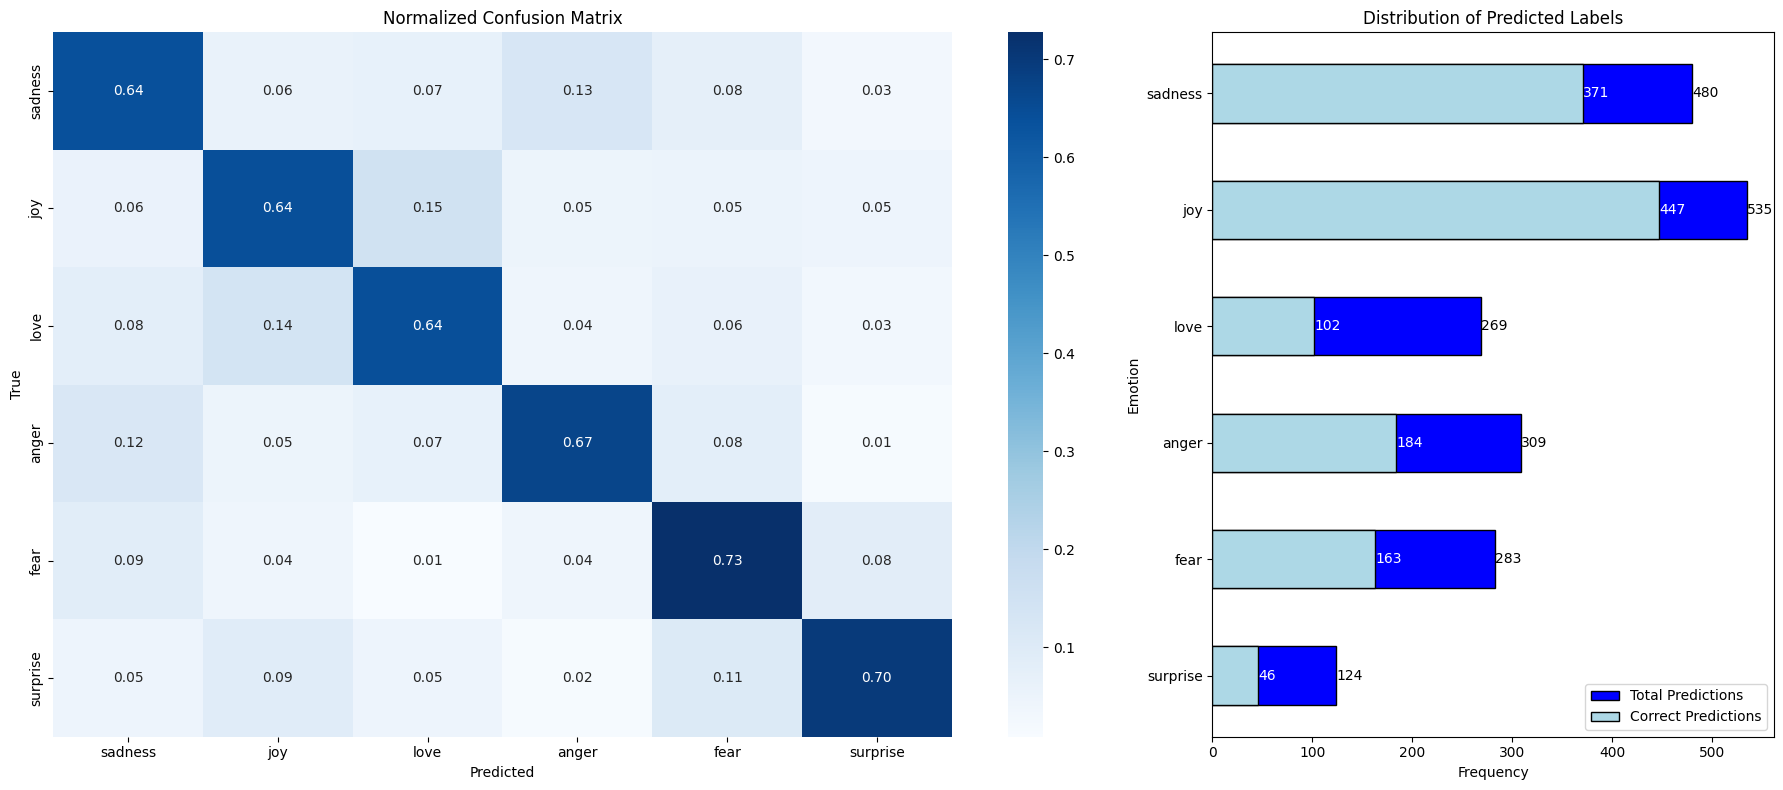


Time of execution: 1073.664006948471 seconds


In [ ]:
classify_emotions(cohere_api_key, emotion['train'], emotion['test'], batch_size=50, num_examples_per_class=400, display_samples=False, model = 'embed-english-v3.0')

**Cohere Classification API Implementation: Conclusions**

---
Cohere API for classificaiton was implemented in 4 variants (each variant with the "embed-english-v3.0" embeddings model applied):
- 50 training examples per class (total of 300 training examples)
- 100 training examples per class (total of 600 training examples)
- 200 training examples per calss (total of 1200 training examples)
- 400 training examples per class (Total of 2400 examples)

Surprisingly, the state-of-the-art large language model such as the one offered by Cohere, achieved very weak results when compared to other models implemented in the previous steps. Also improvement in accuracy was observed with the increase of training examples.

The top perforormance on the test dataset was achieved by the implementation with 2400 total training examples (400 per class).

**Accuracy of test predictions: 65.65%**

Although the result was much weaker then in the case of other models, it is important to mention that this technique did not perform any training, but classifies based on similarity of input vectors to vectors generated from training examples with much smaller number of training examples (2.400) than the previous models (16.000). At this stage it is also important to reflect on long inference time of Cohere API, which is acceptable for the use-case of tet classification for analysis (in contrast to implementation in user-facing products), however, for massive datasets such a long inference time can be a huge barrier for the business. Another thing to mention in this context is that despite of relatively high accuracy, the Cohere Classify API produces a high number of False Positives, which might be a big problem especially in smaller classes like surprised in which the True Positive rate is relatively high, whereas also other, larger classes are often classified as Surprised, causing the Surprised class to have way more False Positives than True Positives.
 In the further stages of the project the Fine-Tuned classification could be implemented to see how the performance can improve if the embeddings used by the Cohere API to classify new samples will be fine-tuned to the training data provided for the task.


### Final Consclusions and Recommendations

***THE TABLE WITH ALL MODELS AND THEIR STATISTICS IS ATTACHED TO THE SUBMISSION IN CASE IT DOES NOT DISPLAY IN THE NOTEBOOK***

IN the project I trained the following models to find the best performing one for the task of classification emotions based on text:
- RNNs (One and Two layers) with custom embeddings trained in 200 dimensions
- LSTMs (One and Two layers) with custom embeddings trained in 200 dimensions
- LSTMs with Pre-Trained Embeddings (Glove-Twitter)
- Small Bert

Also Cohere classification API was implemented to classify the test data.
<br><br>

**Recommendations**

After in-depth analysis of the test performance of the models it is recommended to implement One-Layered LSTM with custom trained embeddings of 200 dimensions, as it achieved the highest test accuracy of 91.6%. For business application this accuracy is very suitable and can comfortably be used in various text analysis such as analysis of social media interactions of users with the brand or analysis of emotions in business reviews online (Google Reviews, Yelp, Tripadvisor, TrustPilot etc.).

Further improvement in the model performance might be achieved by:
1. Fine-Tuning more complex pre-trained BERT architecture (that would require higher computational resources)
2. Fine-Tuning Cohere classification endpoint with training data to obtain Cohere Classifiation embeddings suited for the vocabulary and texts formats present in the datasets.